<h1 style="font-size: 50px;">Análisis de los restaurantes con éxito</h1>

# Introducción

Imaginemos el caso de un empresario que desea abrir un restaurante pero no sabe dónde ubicarlo. Con este escenario en mente, hemos decidido realizar un **análisis geográfico** para identificar las ubicaciones de los restaurantes más exitosos en función del barrio o de ciertos subgrupos de distritos de Madrid.

Para llevar a cabo este análisis, hemos desarrollado una métrica que cuantifica el éxito de los restaurantes, basada en dos elementos clave:

1. **Potencial:** Una medida calculada utilizando distancias para identificar zonas de mayor éxito.
2. **Dirección principal:** Un análisis que muestra hacia dónde tienden a agruparse los restaurantes más exitosos.

Además, consideramos que la ubicación óptima de un restaurante debe tener en cuenta estas dos variables, complementadas por la **teoría de Hotelling**. Esta teoría sostiene que los negocios competidores tienden a agruparse en lugar de dispersarse, lo que les permite obtener ventajas económicas y atraer a un mayor número de clientes. 

En resumen, los restaurantes más exitosos tienden a ubicarse en zonas con alta concentración de establecimientos similares. Por lo tanto, para maximizar las posibilidades de éxito, el empresario debería considerar ubicar su restaurante cerca de estas áreas de alta agrupación.


# Ejecución del código

Importamos los módulos a emplear

In [63]:
import pandas as pd 
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from typing import List, Dict

# Limpieza del Fichero de Datos

A continuación, realizamos la limpieza del fichero de datos, que contiene información sobre los distritos y barrios de Madrid:

1. **Eliminar valores NA:**
   - Eliminamos los valores faltantes (`NA`) en la columna `NOMBRE_DISTRITO`.

2. **Seleccionar columnas relevantes:**
   - Tomamos únicamente las siguientes columnas:
     - `Lat`
     - `Long`
     - `Number of Ratings`
     - `Restaurant Rating`
     - `Number of Bookmarks`
     - `NOMBRE_DISTRITO`
     - `NOMBRE_BARRIO`

3. **Reindexar el DataFrame:**
   - Asignamos un nuevo índice que va desde `0` hasta la longitud total del DataFrame limpio.


In [64]:
data = pd.read_csv("../ficheros_csv/restaurantes_con_distrito_barrio.csv")
areas = data
areas = areas.dropna()
datos_necesarios = areas[["Lat", "Long", "Number of Ratings", "Restaurant Rating", "Number of Bookmarks", "NOMBRE_DISTRITO", "NOMBRE_BARRIO"]]
datos_necesarios.index = np.arange(0,len(datos_necesarios))

# Clasificación de Distritos

Para realizar un análisis más eficiente, hemos dividido los distritos de Madrid en dos categorías basadas en la cantidad de restaurantes que contienen:

1. **Distritos con más de 100 restaurantes:**
   - Estos distritos se dividen adicionalmente en **barrios**, para facilitar un mejor manejo y análisis de los datos.

2. **Distritos con menos de 100 restaurantes:**
   - Se mantienen sin subdividir, ya que su menor volumen de datos permite un análisis directo.

Esta clasificación nos permite adaptar el enfoque analítico según la densidad de restaurantes en cada distrito.


In [65]:
grupo_distrito = datos_necesarios.groupby("NOMBRE_DISTRITO").size()
grupo_distrito_bueno = grupo_distrito[grupo_distrito<=100]
lista_bueno_split: List[str] = list(grupo_distrito_bueno.index) #Lo convertimos en listas
grupo_distrito_demasiado = grupo_distrito[grupo_distrito>100]
lista_distritos_split: List[str] = list(grupo_distrito_demasiado.index) #Lo convertimos en listas
print(lista_bueno_split)
print(lista_distritos_split)
print(f"{grupo_distrito}\n")

#Una vez clasificados los grupos, tomamos la lista de los distritos con más de 100 restaurantes y los agrupamos en una lista de barrios 
lista_barrios: List[str] = []
for distrito in lista_distritos_split:
    restaurantes_distrito = datos_necesarios[datos_necesarios["NOMBRE_DISTRITO"] == distrito]
    grupo_barrio = restaurantes_distrito.groupby("NOMBRE_BARRIO").size()
    print(grupo_barrio)
    lista_barrios = lista_barrios + list(grupo_barrio.index)


['Arganzuela', 'Barajas', 'Carabanchel', 'Chamartin', 'Chamberi', 'Ciudad Lineal', 'Fuencarral-El Pardo', 'Hortaleza', 'Latina', 'Moncloa-Aravaca', 'Moratalaz', 'Puente de Vallecas', 'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuan', 'Usera', 'Vicalvaro', 'Villa de Vallecas']
['Centro']
NOMBRE_DISTRITO
Arganzuela                34
Barajas                   18
Carabanchel                4
Centro                   378
Chamartin                 13
Chamberi                  69
Ciudad Lineal              7
Fuencarral-El Pardo        8
Hortaleza                  9
Latina                    11
Moncloa-Aravaca           16
Moratalaz                  3
Puente de Vallecas         8
Retiro                    19
Salamanca                 64
San Blas - Canillejas      8
Tetuan                    20
Usera                      4
Vicalvaro                  3
Villa de Vallecas          4
dtype: int64

NOMBRE_BARRIO
Cortes          41
Embajadores    102
Justicia        75
Palacio         37
Sol  

# Agrupación y Clasificación de Distritos y Restaurantes

Para optimizar el análisis, hemos decidido agrupar los distritos y clasificar los restaurantes de acuerdo con su grado de éxito. Este es el procedimiento que seguiremos:

---

## 1. Agrupación de Distritos
- **Distritos con pocos restaurantes:**
  - Se agruparán en conjuntos para facilitar su análisis.
  
- **Distritos con más de 20 restaurantes:**
  - Se mantendrán como entidades individuales para un análisis más detallado.

---

## 2. Creación de un Diccionario de DataFrames
- Cada clave (`key`) del diccionario representará una **zona** (grupo de distritos o un distrito individual).
- Cada valor será un **DataFrame** que contiene los datos correspondientes a esa zona.

---

## 3. Inclusión de Nuevas Columnas en los DataFrames
### **a) Success Ratio**
- Esta métrica calcula el grado de éxito de un restaurante en un grupo determinado.  
- La fórmula utilizada es:  
  $$
  \text{Success Ratio} = (\text{"Number of Ratings"} \times \text{"Restaurant Rating"}) + \text{"Number of Bookmarks"}
  $$
  - **Normalización:** El producto se normaliza entre 0 y 1 para garantizar comparabilidad con "Number of Bookmarks" que también se normaliza.

### **b) Quality Classification**
- Clasificación de los restaurantes basada en el percentil de su **Success Ratio**:
  - **Hasta el percentil 65:**  
    Restaurantes que menos destacan; aunque siguen en pie, no son particularmente exitosos.
  - **Percentil 65 al 80:**  
    Restaurantes con éxito ambiguo (**lógica borrosa**), no podemos determinar con certeza su nivel de éxito.
  - **A partir del percentil 80:**  
    Restaurantes que claramente tienen un mayor éxito en su grupo.

---

Este enfoque nos permite analizar la distribución del éxito y comprender las características de los restaurantes en cada zona, ayudando a identificar tendencias y patrones clave.


In [66]:
# Diccionario de los grupos de distritos
juntar_distritos: Dict[str, List[str]]  = {"Arganzuela": ["Arganzuela"], 
                                            "Chamberi": ["Chamberi"], 
                                            "Salamanca": ["Salamanca"], 
                                            "Sector_Norte": ["Fuencarral-El Pardo", "Barajas", "Chamartin", "Hortaleza", "Tetuan"],
                                            "Sector_Sureste": ["Ciudad Lineal", "Moratalaz", "Villa de Vallecas", "Vicalvaro", "Puente de Vallecas", "Retiro", "San Blas - Canillejas"],
                                            "Sector_Suroreste": ["Carabanchel", "Latina", "Moncloa-Aravaca", "Usera"]}

# Creamos el modelo para escalar los datos
modelo = MinMaxScaler(feature_range=(0, 1))

# Creamos una función que implementará los cálculos para la creación de las dos columnas en los dataframes
def agrupar_en_diccionario(datos, modelo):
    """
    PRE
        - dataframe: dataframe de los datos 
        - diccionario: el diccionario a almacenar los datos el dataframe
    POST
        Retorna un dataframe añadiendo las columnas "Success ratio" y "quality_classification"
    """
    datos["Number of Bookmarks"] = modelo.fit_transform(pd.DataFrame(datos["Number of Bookmarks"]))
    datos["Success ratio"] = modelo.fit_transform(pd.DataFrame(datos["Number of Ratings"] * datos["Restaurant Rating"]))
    datos["Success ratio"] = datos["Success ratio"] + datos["Number of Bookmarks"]
    inicio_frontera_borrosa = datos["Success ratio"].quantile(0.65)
    fin_frontera_borrosa = datos["Success ratio"].quantile(0.8) 
    def calificacion(x):
        if x < inicio_frontera_borrosa:
            return 1
        elif inicio_frontera_borrosa <= x < fin_frontera_borrosa:
            return 2
        else:
            return 3
    datos["quality_classification"] = datos["Success ratio"].map(calificacion)
    return datos


# Inicializamos con un diccionario vacío y le vamos incluyendo los dataframes de los grupos y los barrios
diccionario_grupos = {}

# Distritos
for distrito in juntar_distritos:
    # Con el dataframe original, tomamos las filas que correspondan con alguno de los valores en el conjunto de distritos empleando un apply
    data_frame = datos_necesarios[datos_necesarios["NOMBRE_DISTRITO"].apply(lambda x: x in juntar_distritos[distrito])] 

    # Reestablecemos los índices para que quede conforme con el nuevo dataframe
    data_frame.index = np.arange(0, len(data_frame))

    # Aplicamos la función para crear el dataframe con las nuevas columnas
    data_frame_mejorado = agrupar_en_diccionario(data_frame, modelo)

    # Lo guardamos en el diccionario
    diccionario_grupos[distrito] = data_frame_mejorado

# Barrios
for barrio in lista_barrios:

    # Tomamos los valores del dataframe original que tenga como barrio "barrio"
    data_frame = datos_necesarios[datos_necesarios["NOMBRE_BARRIO"]==barrio]

    # Reestablecemos los índices para que quede conforme con el nuevo dataframe
    data_frame.index = np.arange(0,len(data_frame))
    
    # Aplicamos la función para crear el dataframe con las nuevas columnas
    data_frame_mejorado = agrupar_en_diccionario(data_frame, modelo)

    # Lo guardamos en el diccionario
    diccionario_grupos[barrio] = data_frame_mejorado


print(diccionario_grupos["Arganzuela"])



          Lat      Long  Number of Ratings  Restaurant Rating  \
0   40.408558 -3.716881                1.0                3.0   
1   40.409489 -3.718675                2.0                4.0   
2   40.404800 -3.708088                2.0                2.5   
3   40.404414 -3.702664                2.0                2.0   
4   40.405221 -3.697371                9.0                3.5   
5   40.406073 -3.694934                9.0                4.0   
6   40.404220 -3.702246                3.0                4.5   
7   40.409656 -3.721005               35.0                5.0   
8   40.404923 -3.712790               37.0                5.0   
9   40.404526 -3.696628                3.0                3.0   
10  40.406064 -3.692670                3.0                4.0   
11  40.406687 -3.689563                0.0                0.0   
12  40.402910 -3.697292               28.0                5.0   
13  40.403242 -3.713693                0.0                0.0   
14  40.402888 -3.697183  

C:\Users\josej\AppData\Local\Temp\ipykernel_28108\3990305331.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos["Number of Bookmarks"] = modelo.fit_transform(pd.DataFrame(datos["Number of Bookmarks"]))
C:\Users\josej\AppData\Local\Temp\ipykernel_28108\3990305331.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos["Success ratio"] = modelo.fit_transform(pd.DataFrame(datos["Number of Ratings"] * datos["Restaurant Rating"]))
C:\Users\josej\AppData\Local\Temp\ipykernel_28108\3990305331.py:23: Set

# Importación y Preparación de Datos Geográficos

Vamos a importar el fichero que contiene el diseño de las fronteras de los **distritos** y **barrios de Madrid**. Posteriormente, convertiremos los valores de **Longitud** y **Latitud** a formato decimal para representarlos adecuadamente en las gráficas.

### Mapeo de Distritos a Barrios
Se utiliza un diccionario para asignar los distritos y barrios


In [67]:
""" 
Diccionario con las listas de los datos de las zonas como vienen dados en los ficheros geográficos.
El primer valor de la lista corresponde a si la zona es un distrito o un barrio
Los valores siguientes corresponden a los ids del distrito o del barrio tal y como vienen en los ficheros geográficos
""" 
mapeo_distrito_barrio: Dict[str, List[int]] = {"Arganzuela": [0, 1], 
                                                "Chamberi": [0, 6], 
                                                "Salamanca": [0, 3], 
                                                "Sector_Norte": [0, 7, 20, 4, 15, 5],
                                                "Sector_Sureste": [0, 14, 13, 17, 18, 12, 2, 19],
                                                "Sector_Suroreste": [0, 10, 9, 8, 11],
                                                "Cortes": [1, 2],
                                                "Embajadores": [1, 1],
                                                "Justicia": [1, 3],
                                                "Palacio": [1, 0],
                                                "Sol": [1, 5],
                                                "Universidad": [1, 4]}


# Importamos los ficheros y los guardamos en las variables madrid (para distritos) y barrios_madrid (para barrios)
madrid = gpd.read_file("mapa_madrid\Distritos.shp")
barrios_madrid = gpd.read_file("mapa_madrid\Barrios.shx")

# Los convertimos en los valores decimales de Longitud y Latitud
madrid = madrid.set_crs("EPSG:25830", allow_override=True)
madrid = madrid.to_crs("EPSG:4326")
barrios_madrid = barrios_madrid.set_crs("EPSG:25830", allow_override=True)
barrios_madrid = barrios_madrid.to_crs("EPSG:4326")

<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\B'
<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\B'
C:\Users\josej\AppData\Local\Temp\ipykernel_28108\3008564637.py:21: SyntaxWarning: invalid escape sequence '\D'
  madrid = gpd.read_file("mapa_madrid\Distritos.shp")
C:\Users\josej\AppData\Local\Temp\ipykernel_28108\3008564637.py:22: SyntaxWarning: invalid escape sequence '\B'
  barrios_madrid = gpd.read_file("mapa_madrid\Barrios.shx")


# Visualización de Restaurantes en Zonas de Madrid

Una vez preparados los datos, procederemos a graficarlos en una visualización que consiste en **12 subplots** correspondientes a las doce zonas que se van a analizar. En cada subplot, se incluirán los siguientes elementos:

## 1. **Fronteras de los Distritos y Barrios**
- Finalmente, se trazará la **forma geográfica** del distrito, barrio o conjunto de distritos correspondiente, utilizando los datos geoespaciales de los límites de las zonas.

## 2. **Scatterplot de Restaurantes**
- **Ejes:** Longitud y Latitud de cada restaurante.
- **Colores de los puntos:** 
  - El color de cada punto representará la **distancia** del restaurante con respecto a los demás de la zona. 
  - Esta distancia se calcula usando la **norma de Frobenius** de la matriz formada por las coordenadas (Longitud, Latitud) de todos los restaurantes en la zona, excluyendo al restaurante en cuestión.
  
  **Cálculo de la Distancia:**
  - Se calcula la norma de Frobenius como:
    $$
    \text{Distancia} = \|X - x_i\|
    $$
    donde:
    - \( X \) es la matriz de todas las coordenadas de los restaurantes en la zona.
    - \( x_i \) es el vector de coordenadas del restaurante específico.
    
  - Los valores calculados de distancia se almacenarán en una lista. Posteriormente, se clasificarán en 4 categorías según el rango:
    - El intervalo se define como la diferencia entre el máximo y mínimo de las distancias, dividido en 4 subintervalos equiespaciados.
    - Los colores de los puntos en el gráfico corresponderán con estos 4 subintervalos, lo que permitirá visualizar la distribución espacial de los restaurantes en función de su proximidad.

## 3. **Geometría de Restaurantes según Calidad**
- Dibujaremos **pentágonos** alrededor de cada restaurante si su calidad es 3.
- Dibujaremos **rectángulos** si su calidad es 2.
  
Estas figuras geométricas ayudarán a resaltar visualmente los restaurantes con mayor y menor éxito en función de su clasificación de calidad.


## 4. **Direcciones Principales de los Restaurantes**
- Se calcularán dos **rectas** que representan las direcciones principales de los restaurantes en la zona. 
- Estas rectas son ortogonales (aunque la ortogonalidad no se notará visualmente en las gráficas), y se obtendrán utilizando los **vectores singulares** de la descomposición en valores singulares (SVD) de la matriz de coordenadas de los restaurantes con clasificación de calidad 2 y 3.

### Fórmula de Descomposición en Valores Singulares (SVD):
Si \( A \) es la matriz de coordenadas de los restaurantes con calificación 2 y 3, se realiza la descomposición:
$$
A = U S V^T
$$
- \( U \) contiene los vectores singulares del espacio de columnas.
- Los primeros dos vectores en \( V \) representan los vectores singulares del espacio de columnas y tienn las direcciones principales de los restaurantes.


---

Con esta visualización, se proporcionará una representación detallada y clara de los restaurantes en diferentes zonas de Madrid, destacando su distribución, dirección y calidad en función de las métricas definidas.


In [68]:
# Función para calcular el vector singular V
def calculo_vector_V(data, modelo):
    """ 
    PRE:
        - data: es un dataframe que contiene las columnas Lat, Long y quality_classification
    POST:
        nos retorna la matriz V de la matriz de coordenadas limpiadas
    """
    # Normalizamos las columnas Lat y Long para el cálculo de vectores singulares
    data["Lat"] = modelo.fit_transform(data[["Lat"]])
    data["Long"] = modelo.fit_transform(data[["Long"]])
    data = data[data["quality_classification"] > 1]
    matriz_barrio_vectores = np.asmatrix(data[["Lat", "Long"]])
    [U, S, V] = np.linalg.svd(matriz_barrio_vectores)
    return V

In [69]:
# Función para calcular la lista de colores
def lista_distancias(matriz) -> List[str]:
    """ 
    PRE:
        - matriz es una matriz de numpy cuya primera columna corresponde a la longitud y la segund a la latitud
    POST:
        Nos retorna una lista de strings de colores para colorear después
    """
    area_dominio_cada_barrio: List[float] = [] # Inicializamos con una lista vacía
    for i in range(matriz.shape[0]):
        barrio_i = matriz[i,:]
        potencial = np.linalg.norm(matriz-barrio_i)
        area_dominio_cada_barrio.append(float(potencial))

    # Calculamos el máximo de la lista
    maximo = max(area_dominio_cada_barrio)
    
    # Calculamos el mínimo de la lista
    minimo = min(area_dominio_cada_barrio)

    # Calculamos a distacia de un subintervalo
    cuarta = (maximo-minimo)/4

    def colorear(x):
        if minimo <= x < minimo + cuarta:
            return "red"
        elif minimo + cuarta <= x < minimo + 2*cuarta:
            return "blue"
        elif minimo + 2*cuarta <= x < minimo + 3*cuarta:
            return "green"
        else:
            return "purple"
        
    return list(map(colorear, area_dominio_cada_barrio))
    

C:\Users\josej\AppData\Local\Temp\ipykernel_28108\3764688634.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Lat"] = modelo.fit_transform(data[["Lat"]])
C:\Users\josej\AppData\Local\Temp\ipykernel_28108\3764688634.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Long"] = modelo.fit_transform(data[["Long"]])
C:\Users\josej\AppData\Local\Temp\ipykernel_28108\3764688634.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<Figure size 600x600 with 0 Axes>

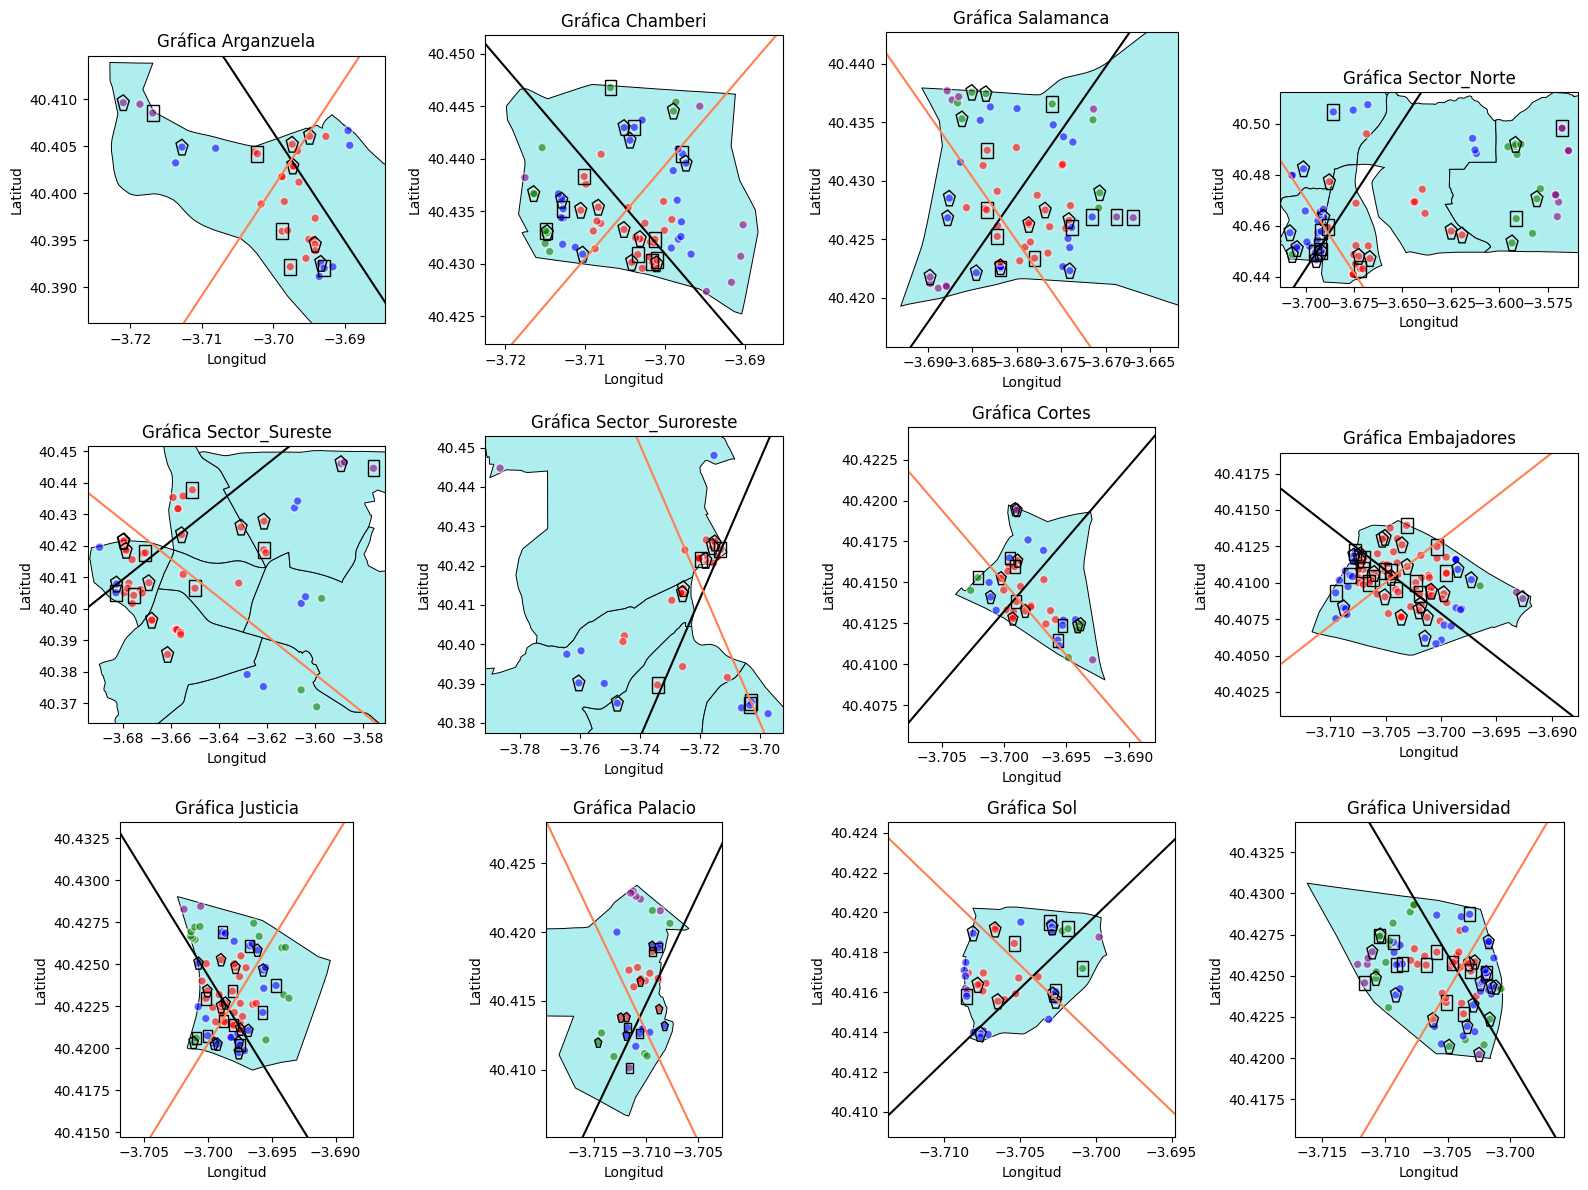

In [70]:
plt.figure(figsize=(6,6))
fig, axs = plt.subplots(3, 4, figsize=(16, 12)) 
axs = axs.flatten() 
index = 0
for grupo in diccionario_grupos:
    sector = diccionario_grupos[grupo]

    # Obtenemos el vector V
    data_frame_barrio = sector[["Lat", "Long"]]
    data_frame_vectores_singulares = sector[["Lat", "Long", "quality_classification"]]
    V = calculo_vector_V(data_frame_vectores_singulares, modelo=modelo)

    # Obtenemos la lista de colores para pintar.
    matriz_barrio = np.asmatrix(data_frame_barrio)
    area_dominio_cada_barrio = lista_distancias(matriz_barrio)

    # Inicializamos el subplot en su índice correspondiente
    ax = axs[index]
    

    """ 
    1 Dibujamos la zona de Madrid:
    Para ello calculamos el lugar a partir del diccionario, teniendo en cuenta cómo hemos colocado los valores en la lista y hacemos un plot. 
    """
    # Establecemos las zonas de Madrid para pintar su frontera
    zona = mapeo_distrito_barrio[grupo]
    if zona[0] == 0:
        lugar = madrid.iloc[zona[1:len(zona)]]
    else:
        lugar = barrios_madrid.iloc[zona[1:len(zona)]]

    lugar.plot(linewidth=0.7, ax=ax, edgecolor='black', color="paleturquoise")


    """
    2 Dibujamos los puntos (longitud, latitud) de cada restaurante en su zona:
    Hacemos uso de la lista de colores que obtuvimos antes
    """
    ax.scatter(np.array(data_frame_barrio["Long"]), np.array(data_frame_barrio["Lat"]), c=np.array(area_dominio_cada_barrio),alpha=0.6, edgecolors="w", linewidth=1)


    """ 
    3 Dibujamos los polígonos resaltar los restaurantes exitosos y los no tenemos la total certeza:
    Calculamos el contorno que es el 2% de la longitud del intervalo de Longitud para calcular los lados de los pentágonos y rectángulos.
    Con un bucle los dibujamos según si la clasificación es 2 o 3
    """

    x_max = np.max(data_frame_barrio["Long"])+0.005
    x_min = np.min(data_frame_barrio["Long"])-0.005
    y_max = np.max(data_frame_barrio["Lat"])+0.005
    y_min = np.min(data_frame_barrio["Lat"])-0.005

    contorno = (x_max-x_min)*0.02   # Contorno general
    #Contornos para pentágono
    contorno_mitad = contorno/2
    contorno_pentagono = contorno_mitad/2

    for i in range(len(sector)):
        if sector.loc[i,"quality_classification"] == 2: # Rectángulo
            polygon = plt.Polygon([(sector.loc[i,"Long"]-contorno, sector.loc[i, "Lat"]-contorno), 
                                (sector.loc[i,"Long"]+contorno, sector.loc[i, "Lat"]-contorno), 
                                (sector.loc[i,"Long"]+contorno, sector.loc[i, "Lat"]+contorno), 
                                (sector.loc[i,"Long"]-contorno, sector.loc[i, "Lat"]+contorno)], closed=True, fill=None, edgecolor='k')
            ax.add_patch(polygon)
            
        elif sector.loc[i,"quality_classification"] == 3: # Pentágono
            polygon = plt.Polygon([(sector.loc[i,"Long"], sector.loc[i, "Lat"]+contorno),
                                (sector.loc[i,"Long"]-contorno, sector.loc[i, "Lat"]+contorno_mitad), 
                                (sector.loc[i,"Long"]-contorno_mitad, sector.loc[i, "Lat"]-contorno), 
                                (sector.loc[i,"Long"]+contorno_mitad, sector.loc[i, "Lat"]-contorno), 
                                (sector.loc[i,"Long"]+contorno, sector.loc[i, "Lat"]+contorno_pentagono)], closed=True, fill=None, edgecolor='k')
            ax.add_patch(polygon)


    """ 
    4 Dibujamos las rectas cuyo vector director son cada uno de los vectores singulares:
    Debemos centrar las rectas y establecer un espaciado para la x
    """

    # Centramos los datos
    center_x = sector[sector["quality_classification"] > 1]["Long"].median()
    center_y = sector[sector["quality_classification"] > 1]["Lat"].median()

    # Creamos las rectas ajustadas al centro
    x = np.linspace(x_min, x_max, 20000)  # Definimos el rango de x para las rectas
    y1 = (V[1, 0] / V[0, 0]) * (x - center_x) + center_y
    y2 = (V[0, 1] / V[1, 1]) * (x - center_x) + center_y

    # Los dibujamos en el subplot
    ax.plot(x, y1, color="k")
    ax.plot(x, y2, color="coral")

    # Ajustamos los límites de los ejes y añadimos los títulos y las etiquetas
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"Gráfica {grupo}")
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    
    
    index += 1  # Actualizamos el índice


# Una vez terminado de pintar, lo guardamos en un un png y lo mostramos
plt.tight_layout()
plt.savefig("figuras\\figura_completa.png")
plt.show()


